In [52]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier



from sklearn.manifold import TSNE
import plotly as py
import cufflinks as cf
py.offline.init_notebook_mode(connected=True)
cf.go_offline()
import plotly.io as pio
pio.renderers.default='notebook'

In [53]:
df = pd.read_csv('training_set.csv') # Importing the training dataset
df.head(2)

,label,cleaned_article,num_punctuations,no_of_stopwords,no_of_quesMarks,no_of_exclamation,no_of_sentence,sentiment,cc_cd,determiner,...,noun,adverb,verb,article_len,negations,polarity,word_count,avg_word_len,num_unique_words,num_chars
0,1,seeking best woman final return fridaysunday y...,139,634,5,0,41,Positive,37,98,...,236,27,150,4563,6,0.049887,357,6.392157,234,2638
1,0,harsh reality come taking responsibility life ...,112,702,2,3,37,Positive,53,79,...,196,85,230,5470,15,0.029320,347,6.573487,263,2627


In [54]:
df.shape

(96517, 24)

In [55]:
#df = df[['cleaned_article', 'label', 'num_punctuations', 'no_of_quesMarks', 'sentiment', 'no_of_exclamation', 'foreign_w', 'modal', 'polarity', 'avg_word_len']]


In [56]:
# Sentiment is a categorical data, we have to encode it for model training
from sklearn.preprocessing import OneHotEncoder
def Encoding_sentiment(df):
    df.dropna(inplace = True)
    encoder = OneHotEncoder(drop = 'first') # Creating object of OneHotEncoder class
    encoded_sentiment = encoder.fit_transform(pd.DataFrame(df['sentiment'])).toarray().astype(int) # Fitting to the data
    column_names = encoder.get_feature_names_out() # Getting feature name
    encoded_sentiment = pd.DataFrame(encoded_sentiment, columns = column_names)  # Creating dataframe of encoded feature
    df_new = pd.concat([df, encoded_sentiment], axis = 1) # Concatinating newly created sentiment dataframe into original dataframe
    df_new.drop('sentiment', axis = 1, inplace = True) # dropping sentiment column as I have already encoded this categorical feature

    return df_new

In [57]:
df = Encoding_sentiment(df) # Calling the function to encode Sentiment column which is a categorial feature

In [58]:
df.columns

Index(['label', 'cleaned_article', 'num_punctuations', 'no_of_stopwords',
       'no_of_quesMarks', 'no_of_exclamation', 'no_of_sentence', 'cc_cd',
       'determiner', 'foreign_w', 'conj_prep', 'adjective', 'modal', 'noun',
       'adverb', 'verb', 'article_len', 'negations', 'polarity', 'word_count',
       'avg_word_len', 'num_unique_words', 'num_chars', 'sentiment_Neutral',
       'sentiment_Positive'],
      dtype='object')

In [59]:
df = df[(df['word_count'] >7) & (df['word_count']<800)]
len(df)

90697

# Model Building

In [60]:
X = df.drop(['cleaned_article'], axis = 1) # Training features
y = df['label'] # Target variable

In [61]:
# Creating train and test vextor for model training and testing
from sklearn.model_selection import train_test_split
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X, y, test_size=0.2, random_state=20)

In [62]:
X_train = X_train_og.drop(['label'], axis = 1)
X_test = X_test_og.drop(['label'], axis = 1).values
y_train = y_train_og.values
y_test = y_test_og.values

In [63]:
# Scaling the data using Standard Scaler with mean = 0 and standard deviation = 1
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [64]:
# Importing testing dataset 1
test_df1 = pd.read_csv('Test/test1.csv') 
# Removing all those rows which has count of article words less than 7 or greater than 800
test_df1 = test_df1[(test_df1['word_count'] > 7) & (test_df1['word_count'] < 800)]  

test_df1 = Encoding_sentiment(test_df1) # Encoding categorical features
test_df1.dropna(inplace = True)

test_df1.label = test_df1.label.astype(int)
test_X1 = test_df1.drop(['cleaned_article','label'], axis = 1).values # Testing features
label_y1 = test_df1['label'].values # Testing labels
test_X1 = sc.transform(test_X1) # scaling features

In [65]:
# Importing testing dataset 2 and necessary coversation for model building and feature transformation
test_df2 = pd.read_csv('Test/test2.csv')
test_df2.fillna('', inplace = True)
test_df2 = test_df2[(test_df2['word_count'] > 7) & (test_df2['word_count'] < 800)]
test_df2 = Encoding_sentiment(test_df2)
test_df2.dropna(inplace = True)
print(test_df1.isna().sum())
test_df2.label = test_df2.label.astype(int)

test_X2 = test_df2.drop(['cleaned_article','label'], axis = 1).values
test_df2.dropna(inplace = True)
label_y2 = test_df2['label'].values
test_X2 = sc.transform(test_X2)

label                 0
cleaned_article       0
num_punctuations      0
no_of_stopwords       0
no_of_quesMarks       0
no_of_exclamation     0
no_of_sentence        0
cc_cd                 0
determiner            0
foreign_w             0
conj_prep             0
adjective             0
modal                 0
noun                  0
adverb                0
verb                  0
article_len           0
negations             0
polarity              0
word_count            0
avg_word_len          0
num_unique_words      0
num_chars             0
sentiment_Neutral     0
sentiment_Positive    0
dtype: int64


## Logistic Regression

In [66]:
log_cls = LogisticRegression(penalty='l2', max_iter=400, n_jobs=-1, C=1) # creating class object
log_cls.fit(X_train, y_train) # fitting to the training set

log_ypred = log_cls.predict(X_test) # predicting on testset

<AxesSubplot:>

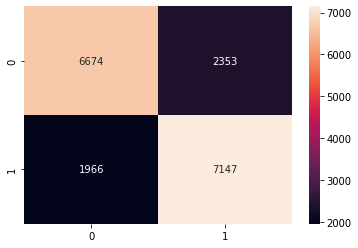

In [67]:
cm = confusion_matrix(y_test, log_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [68]:
# Classification report of test set
print(classification_report(y_test, log_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7725    0.7393    0.7555      9027
           1     0.7523    0.7843    0.7680      9113

    accuracy                         0.7619     18140
   macro avg     0.7624    0.7618    0.7617     18140
weighted avg     0.7623    0.7619    0.7618     18140



In [69]:
# Predicting on first test dataset
test1_log_ypred = log_cls.predict(test_X1)
print(classification_report(label_y1, test1_log_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6899    0.4591    0.5513      2544
           1     0.4911    0.7167    0.5828      1853

    accuracy                         0.5677      4397
   macro avg     0.5905    0.5879    0.5671      4397
weighted avg     0.6061    0.5677    0.5646      4397



In [70]:
# Predicting on 2nd test dataset
test2_log_pred = log_cls.predict(test_X2)
print(classification_report(label_y2, test2_log_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.6086    0.6150    0.6118      2675
           1     0.6213    0.6150    0.6181      2748

    accuracy                         0.6150      5423
   macro avg     0.6150    0.6150    0.6149      5423
weighted avg     0.6150    0.6150    0.6150      5423



### Inference:

From he above classification report we can see model is performing satisfactory on training datatset with accuracy of about 76%. However, model is not good enough to predict on test dataset. The accuracy on 1st test data is 57% and on 2nd dataset it is 62%. 

## K-NN

<AxesSubplot:>

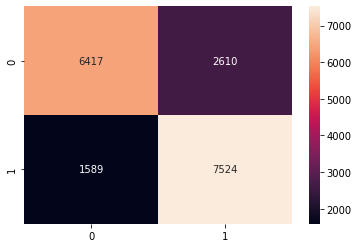

In [71]:
knn_cls = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn_cls.fit(X_train, y_train)
knn_ypred = knn_cls.predict(X_test)

cm = confusion_matrix(y_test, knn_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [72]:
# Classification report on test set
print(classification_report(y_test, knn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.8015    0.7109    0.7535      9027
           1     0.7425    0.8256    0.7818      9113

    accuracy                         0.7685     18140
   macro avg     0.7720    0.7683    0.7677     18140
weighted avg     0.7718    0.7685    0.7677     18140



In [73]:
# Classification report for test-1 dataset
test1_knn_ypred = knn_cls.predict(test_X1)
print(classification_report(label_y1, test1_knn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7499    0.5020    0.6014      2544
           1     0.5297    0.7701    0.6277      1853

    accuracy                         0.6150      4397
   macro avg     0.6398    0.6360    0.6145      4397
weighted avg     0.6571    0.6150    0.6124      4397



In [74]:
# Classification report for test-2 dataset
test2_knn_ypred = knn_cls.predict(test_X2)
print(classification_report(label_y2, test2_knn_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6574    0.6385    0.6478      2675
           1     0.6577    0.6761    0.6668      2748

    accuracy                         0.6576      5423
   macro avg     0.6576    0.6573    0.6573      5423
weighted avg     0.6576    0.6576    0.6574      5423



### Inference:
From the above performance of KNN algorithm, we can see model is giving 77% accuracy on test set, 62% on 1st test dataset and 66% on 2nd test dataset. One thing which need to be observed is that even though KNN does not have good accuracy on training set, it is giving good accuracy compared to other algorithms on 1st first test dataset which is completely different from training set.

## Linear SVM

<AxesSubplot:>

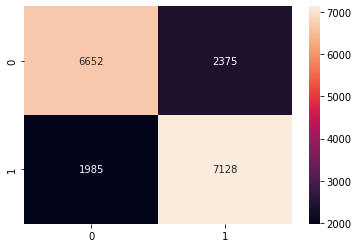

In [79]:

svm_clf = LinearSVC(max_iter = 1500)
svm_clf.fit(X_train, y_train)
svm_ypred = svm_clf.predict(X_test)

cm = confusion_matrix(y_test, svm_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [80]:
# Classification report on train-test data
print(classification_report(y_test, svm_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7702    0.7369    0.7532      9027
           1     0.7501    0.7822    0.7658      9113

    accuracy                         0.7596     18140
   macro avg     0.7601    0.7595    0.7595     18140
weighted avg     0.7601    0.7596    0.7595     18140



In [81]:
# Classification report for test-1 dataset
test1_svm_ypred = svm_clf.predict(test_X1)
print(classification_report(label_y1, test1_svm_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6870    0.4607    0.5515      2544
           1     0.4902    0.7118    0.5805      1853

    accuracy                         0.5665      4397
   macro avg     0.5886    0.5863    0.5660      4397
weighted avg     0.6040    0.5665    0.5638      4397



In [82]:
# Classification report for test-2 dataset
test2_svm_ypred = svm_clf.predict(test_X2)
print(classification_report(label_y2, test2_svm_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6068    0.6116    0.6092      2675
           1     0.6190    0.6143    0.6166      2748

    accuracy                         0.6129      5423
   macro avg     0.6129    0.6129    0.6129      5423
weighted avg     0.6130    0.6129    0.6130      5423



### Inference:

From the above classification report we can see our model is performing satisfactory on test set with accuracy of about 76%. However, model is not good enough to predict on test datasets. The accuracy on 1st test data is 56.65% and on 2nd dataset it is 61.29%. 

### Passive Aggressive Classifier

<AxesSubplot:>

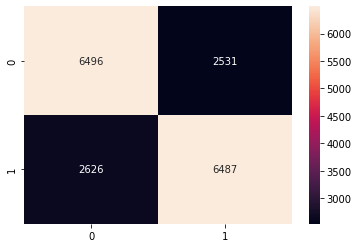

In [108]:
from sklearn.linear_model import PassiveAggressiveClassifier


pac_cls = PassiveAggressiveClassifier(max_iter=2500, C = 0.1, n_jobs=-1) # creating class object
pac_cls.fit(X_train, y_train) # fitting to the training set

pac_ypred = pac_cls.predict(X_test) # predicting on testset

# Ploting Confusion Matrix
cm = confusion_matrix(y_test, pac_ypred)
sn.heatmap(cm, annot=True, fmt="d")

In [109]:
print(classification_report(y_test, pac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7121    0.7196    0.7159      9027
           1     0.7193    0.7118    0.7156      9113

    accuracy                         0.7157     18140
   macro avg     0.7157    0.7157    0.7157     18140
weighted avg     0.7157    0.7157    0.7157     18140



In [110]:
test1_pac_ypred = pac_cls.predict(test_X1)
print(classification_report(label_y1, test1_pac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.5943    0.5130    0.5506      2544
           1     0.4371    0.5192    0.4746      1853

    accuracy                         0.5156      4397
   macro avg     0.5157    0.5161    0.5126      4397
weighted avg     0.5280    0.5156    0.5186      4397



In [111]:
test2_pac_ypred = pac_cls.predict(test_X2)
print(classification_report(label_y2, test2_pac_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.5455    0.6516    0.5939      2675
           1     0.5817    0.4716    0.5209      2748

    accuracy                         0.5604      5423
   macro avg     0.5636    0.5616    0.5574      5423
weighted avg     0.5639    0.5604    0.5569      5423



### Inference:
From the above classification report we can see our model is performing satisfactory on test set with accuracy of about 71%. However, model is not good in prediction on test dataset. 

## Random Forest

<AxesSubplot:>

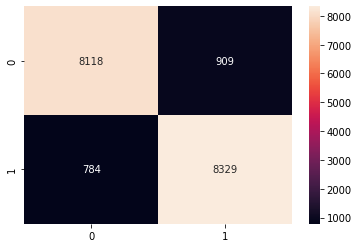

In [75]:
# Creating classifier object
rand_forest_cls = RandomForestClassifier(n_estimators=230, max_depth=27, criterion='entropy', min_samples_split=2, n_jobs = -1)
rand_forest_cls.fit(X_train, y_train) # fitting data on classifier
randForest_ypred = rand_forest_cls.predict(X_test) # making prediction

cm = confusion_matrix(y_test, randForest_ypred)
sn.heatmap(cm, annot=True, fmt="d") #ploting confusion matrix

In [76]:
# Classification report on train-test data
print(classification_report(y_test, randForest_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.9119    0.8993    0.9056      9027
           1     0.9016    0.9140    0.9077      9113

    accuracy                         0.9067     18140
   macro avg     0.9068    0.9066    0.9067     18140
weighted avg     0.9067    0.9067    0.9067     18140



In [77]:
# Classification report for test-1 dataset
test1_rand_ypred = rand_forest_cls.predict(test_X1)
print(classification_report(label_y1, test1_rand_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7504    0.5554    0.6384      2544
           1     0.5501    0.7464    0.6334      1853

    accuracy                         0.6359      4397
   macro avg     0.6503    0.6509    0.6359      4397
weighted avg     0.6660    0.6359    0.6363      4397



In [78]:
# Classification report for test-2 dataset
test2_rand_ypred = rand_forest_cls.predict(test_X2)
print(classification_report(label_y2, test2_rand_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7042    0.9103    0.7941      2675
           1     0.8779    0.6277    0.7320      2748

    accuracy                         0.7671      5423
   macro avg     0.7910    0.7690    0.7630      5423
weighted avg     0.7922    0.7671    0.7626      5423



### Inference:

We can see in the above classification reports that RandForest classifier is giving good accuray compared to other algorithms on all three datasets. We are getting 90+ % accuracy on training dataset and 63% & 77.5% accuracy on test1 and test2 datasets.

## Gradient Boosting

<AxesSubplot:>

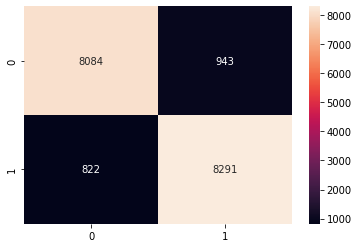

In [83]:

gb_clf = GradientBoostingClassifier(n_estimators=170, learning_rate=0.75, max_depth=27, min_samples_leaf = 5)
gb_clf.fit(X_train, y_train)
gb_ypred = gb_clf.predict(X_test)

cm = confusion_matrix(y_test, gb_ypred)
sn.heatmap(cm, annot=True, fmt="d")


In [84]:
# Classification report on train-test data
print(classification_report(y_test, gb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.9077    0.8955    0.9016      9027
           1     0.8979    0.9098    0.9038      9113

    accuracy                         0.9027     18140
   macro avg     0.9028    0.9027    0.9027     18140
weighted avg     0.9028    0.9027    0.9027     18140



In [85]:
# Classification report for test-1 dataset
test1_gb_ypred = gb_clf.predict(test_X1)
print(classification_report(label_y1, test1_gb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7389    0.5373    0.6222      2544
           1     0.5379    0.7393    0.6227      1853

    accuracy                         0.6225      4397
   macro avg     0.6384    0.6383    0.6225      4397
weighted avg     0.6542    0.6225    0.6224      4397



In [86]:
# Classification report for test-2 dataset
test2_gb_ypred = gb_clf.predict(test_X2)
print(classification_report(label_y2, test2_gb_ypred, digits=4))

              precision    recall  f1-score   support

           0     0.7107    0.9174    0.8009      2675
           1     0.8878    0.6365    0.7414      2748

    accuracy                         0.7750      5423
   macro avg     0.7993    0.7769    0.7712      5423
weighted avg     0.8004    0.7750    0.7708      5423



### Inference:
With 170 interation GB is giving good accuracy on dataset. The model is performing with 90% accuracy on test set also precision and recall is almost same. GB is giving 62% accuracy on 1st test dataset and 78% on 2nd test dataset. It is a boosting algorithm, fine tuning paramerter can give more better result.

### XGBoost Classifier

In [87]:
#! pip install xgboost

<AxesSubplot:>

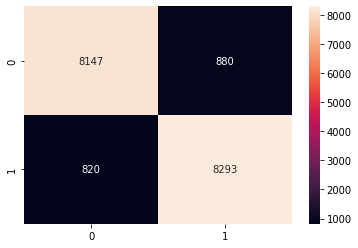

In [88]:
xgb1 = XGBClassifier(
 use_label_encoder=False,
 learning_rate =0.1,
 n_estimators=210,
 #gamma = 0.2,
 max_depth=19,
 min_child_weight=2,
 eval_metric='mlogloss',
 #objective="binary:logistic",
 nthread=-1)

xgb1.fit(X_train, y_train)
xgb_ypred = xgb1.predict(X_test)

cm = confusion_matrix(y_test, xgb_ypred)
sn.heatmap(cm, annot=True, fmt="d")


In [89]:
# Classification report on train-test data
print(classification_report(y_test, xgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.9086    0.9025    0.9055      9027
           1     0.9041    0.9100    0.9070      9113

    accuracy                         0.9063     18140
   macro avg     0.9063    0.9063    0.9063     18140
weighted avg     0.9063    0.9063    0.9063     18140



In [90]:
# Classification report for test-1 dataset
test1_xgb_ypred = xgb1.predict(test_X1)
print(classification_report(label_y1, test1_xgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.7257    0.5303    0.6128      2544
           1     0.5292    0.7248    0.6117      1853

    accuracy                         0.6122      4397
   macro avg     0.6274    0.6275    0.6122      4397
weighted avg     0.6428    0.6122    0.6123      4397



In [91]:
# Classification report for test-2 dataset
test2_xgb_ypred = xgb1.predict(test_X2)
print(classification_report(label_y2, test2_xgb_ypred, digits = 4))

              precision    recall  f1-score   support

           0     0.6989    0.9069    0.7895      2675
           1     0.8724    0.6197    0.7247      2748

    accuracy                         0.7614      5423
   macro avg     0.7857    0.7633    0.7571      5423
weighted avg     0.7869    0.7614    0.7566      5423



### Inference:
This model is performing with 91% accuracy on train dataset also precision and recall is almost same. XGB is giving 61% accuracy on test set1 and 77% on test set 2. XGBoost is a very powerfull alogrim, fine funing this algorithm can outperform other models. It is a boosting algorithm tuning paramerter can give more better result. However, Fine tuning is computationally expensive so I'm avoiding as of now

In [92]:
from sklearn.metrics import accuracy_score
train_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(y_test, log_ypred), 
               accuracy_score(y_test, knn_ypred),
               accuracy_score(y_test, svm_ypred),
               accuracy_score(y_test, randForest_ypred),
               accuracy_score(y_test, gb_ypred),
              accuracy_score(y_test, xgb_ypred)]
})
train_result

,Model,Score
0,Logistic Regression,0.761907
1,KNN,0.768523
2,Linear SVM,0.759647
3,Random Forest,0.906670
4,Gradient Boosting,0.902701
5,XGBoost Classifier,0.906284


### Inference:
> In the above table we can see all tree based algorithms are working almost similar on train_test_split test set. RF, GBDT and XGBoost has achived accuracy of 90% on the test set.

In [93]:
test1_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(label_y1, test1_log_ypred),
               accuracy_score(label_y1, test1_knn_ypred),
               accuracy_score(label_y1, test1_svm_ypred),
              accuracy_score(label_y1, test1_rand_ypred),
               accuracy_score(label_y1, test1_gb_ypred),
               accuracy_score(label_y1, test1_xgb_ypred)
              ]

})

test1_result

,Model,Score
0,Logistic Regression,0.567660
1,KNN,0.614965
2,Linear SVM,0.566523
3,Random Forest,0.635888
4,Gradient Boosting,0.622470
5,XGBoost Classifier,0.612236


### Inference:
> As mentioned before, testset 1 is completely different from training data. This is just to test the model performance when data is unique or different. Here in above table we can see Random Forest is performing better than any other algorithm. However, GBDT and XGBoost has slight variance in performance but both are almost close.

In [94]:
test2_result = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Linear SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost Classifier'],
    'Score' : [accuracy_score(label_y2, test2_log_pred),
               accuracy_score(label_y2, test2_knn_ypred),
              accuracy_score(label_y2, test2_svm_ypred),
              accuracy_score(label_y2, test2_rand_ypred),
               accuracy_score(label_y2, test2_gb_ypred),
               accuracy_score(label_y2, test2_xgb_ypred)
               
              ]

})

test2_result

,Model,Score
0,Logistic Regression,0.614973
1,KNN,0.657570
2,Linear SVM,0.612945
3,Random Forest,0.767103
4,Gradient Boosting,0.775032
5,XGBoost Classifier,0.761387


### Inference:
> Second test dataset is similar to training dataset on subject. Trainig dataset and 2nd test dataset both are based on political news of US election. Here in above table it can been seen clearly tree based algorithms are performing better. GBDT has highet accuracy followed by Random Forest and XGBoost.

## Saving for Error Analysis

### Stategy:

##### Label 0 - Fake News
##### Label 1 - Real News
##### Label 2 - Fake News which are incorrectly classified as Real News
##### Label 3 - Real News which are incorrectly classified as Fake News

In [96]:
# Creating a dataframe for visualization 
# Labeling class 2 for articles incorrectly classified as 1. 
# (In other words, articles with original label 0 which is getting clasified as 1, I am giving it label 2)
# Similarly, labeling as class 3 for all articles which belongs to orginal class 1 but incorectly got classified as 0.
# Idea behind this is just to plot labels so we can identify which is predicted value and find some inference why particular
# article is predicted as 0 or 1.



incorr_df = X_test_og.copy()  # Copying test dataset 
label = incorr_df.label.values # Storing actual labels of test dataset into a variable 

for idx in range(len(X_test_og)):
    #print(idx)
    if label[idx] != randForest_ypred[idx]: # Checking if prediction is not same as original label
        if randForest_ypred[idx] == 1: # Checking if predicted label is 1 (Real) incorrectly
            label[idx] = 2             # Marking that label value as 2
        else:                          
            label[idx] = 3             # if predicted label is 0 (Fake) incorrectly, labelling it as 3
    else:
        continue
        
incorr_df.label = label     # Replacing labels of test dataset with newly created labels


#=================================================================================================================
# Similarly for test set 1

incorr_test_df1 = test_df1.copy()
label_test1 = incorr_test_df1.label.values
for idx in range(len(test_df1)):
    #print(idx)
    if label_test1[idx] != test1_rand_ypred[idx]:
        if test1_rand_ypred[idx] == 1: # Actual label is 0 but model classified it as 1
            label_test1[idx] = 2 # Giving rows a new label for unique identification i.e., 3
        else:
            label_test1[idx] = 3 # All those rows which has actual label as 1 but classified as 0 will be labeled as 4
    else:
        pass
    
incorr_test_df1.label = label_test1


#================================================================================================================
# Similarly for test set 2

incorr_test_df2 = test_df2.copy()
label_test2 = incorr_test_df2.label.values
for idx in range(len(test_df2)):
    #print(idx)
    if label_test2[idx] != test2_rand_ypred[idx]:
        if test2_rand_ypred[idx] == 1: # Actual label is 0 but model classified it as 1
            label_test2[idx] = 2 # Giving rows a new label for unique identification i.e., 2
        else:
            label_test2[idx] = 3 # All those rows which has actual label as 1 but classified as 0 will be labeled as 3
    else:
        pass
    
incorr_test_df2.label = label_test2

In [112]:
incorr_df.to_csv("incorr_df_ErrorAnalysis.csv", index = False)
incorr_test_df1.to_csv("incorr_test_df1.csv", index = False)
incorr_test_df2.to_csv("incorr_test_df2.csv", index = False)